In [1]:
from datetime import datetime
import json

import matplotlib.pyplot as plt
import numpy as np

from search_clustering.pipeline import *
from search_clustering.client import *
from search_clustering.preprocessing import *
from search_clustering.embedding import *
from search_clustering.reduction import *
from search_clustering.clustering.knn import *
from search_clustering.clustering.temporal import *
from search_clustering.labeling import *

In [20]:
query = "virus"
samples = 500
use_cached_data = True

if not use_cached_data:
    es = ElasticClient()

    for index in es.client.indices.get_alias():
        print(index)

    results = es.search(index="faz", field="body", query=query, size=10_000)

    with open(f"datasets/{query.replace(' ', '_')}.json", "w") as json_file:
        json.dump(results, json_file)


with open(f"datasets/{query.replace(' ', '_')}.json", "r") as json_file:
    results = json.load(json_file)
    results = [
        res
        for res in results
        if res["_source"]["publication_date"] is not None
        #and "\n" in res["_source"]["body"]
    ][:samples]


print(f"{len(results)} results")

500 results


# Paragraph-wise Feature Extraction Performance

In [3]:
n = 100
docs = ParagraphSplitter().transform(results[:n])

def measure_time(extractor: Preprocessing):
    start = datetime.now()
    extractor.transform(docs)
    stop = datetime.now()
    delta = stop - start
    return delta.total_seconds()

# LDA
# extractor = ParagraphTopicModeling(language="de")
# print("LDA:", measure_time(extractor))
print("LDA: 1.911818 s")

# SingleRank
# extractor = ParagraphGraphKeyphraseExtractor(language="de")
# print("SingleRank:", measure_time(extractor)
print("SingleRank: 530.79671 s")

# KeyBERT
# extractor = ParagraphLLMKeyphraseExtractor(language="de")
# print("KeyBERT:", measure_time(extractor))
print("KeyBERT: 18.769 s")

LDA: 1.911818 s
SingleRank: 530.79671 s
KeyBERT: 18.769 s


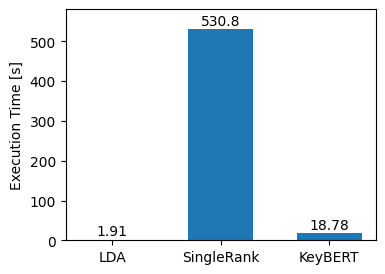

In [172]:
plt.figure(figsize=(4, 3))

x = np.arange(3) / 2
heights = [1.91, 530.80, 18.78]
labels = ["LDA", "SingleRank", "KeyBERT"]
offset = 10

plt.bar(x, heights, 0.3)
for i in range(3):
    plt.text(x[i], heights[i] + offset, heights[i] , ha="center")

plt.xticks(x, ["LDA", "SingleRank", "KeyBERT"])
plt.ylabel("Execution Time [s]")
plt.ylim(0, max(heights) + 5 * offset)
plt.show()

# Clustering Plots

[1/6] Preprocessing


C:\Users\Christopher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


[2/6] Embedding
[3/6] Reducing Dimensionality
[4/6] Clustering
[5/6] Labeling
[6/6] Visualizing


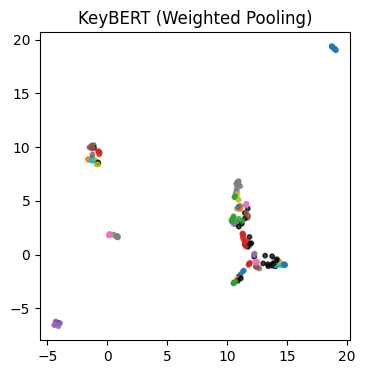

In [17]:
clustering = HierarchicalClustering()

"""
# LDA 1
pipe = KNNPipeline(
    preprocessing=[
        ParagraphSplitter(),
        ParagraphTopicModeling("de"),
        ListJoiner("topics"),
    ],
    embedding=SentenceMiniLM("joined"),
    reduction=Umap(),
    clustering=clustering,
    labeling=FrequentPhrases(language="de"),
)
docs, clusters, labels, score = pipe.fit_transform(results, title="LDA (Concatenation)", legend=False)

# LDA 2
pipe = KNNPipeline(
    preprocessing=[
        ParagraphSplitter(),
        ParagraphTopicModeling("de"),
    ],
    embedding=PooledEmbeddings("topics"),
    reduction=Umap(),
    clustering=clustering,
    labeling=FrequentPhrases(language="de"),
)
pipe.fit_transform(results, title="LDA (Weighted Pooling)", legend=False)

# KPE 1
pipe = KNNPipeline(
    preprocessing=[
        ParagraphSplitter(),
        ParagraphLLMKeyphraseExtractor("de"),
        ListJoiner("keyphrases"),
    ],
    embedding=SentenceMiniLM("joined"),
    reduction=Umap(),
    clustering=clustering,
    labeling=FrequentPhrases(language="de"),
)
docs, clusters, labels, score = pipe.fit_transform(results, title="KeyBERT (Concatenation)", legend=False)
"""
# KPE 2
pipe = KNNPipeline(
    preprocessing=[
        ParagraphSplitter(),
        ParagraphLLMKeyphraseExtractor("de"),
    ],
    embedding=PooledEmbeddings("keyphrases"),
    reduction=Umap(),
    clustering=clustering,
    labeling=FrequentPhrases(language="de", n_phrases=2),
)
docs, clusters, labels, score = pipe.fit_transform(results, title="KeyBERT (Weighted Pooling)", legend=False)

# Temporal Scatterplot

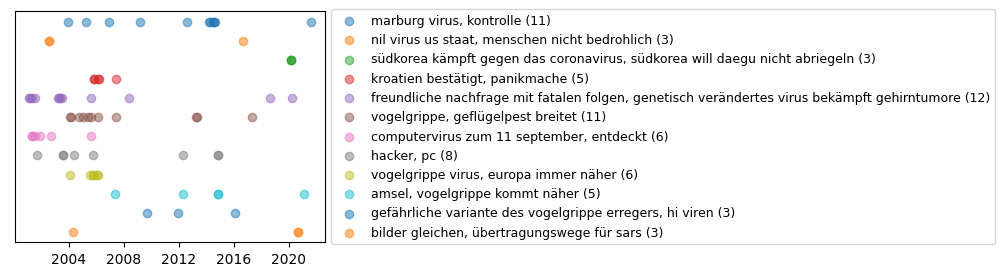

Tote durch Ebola-Ausbruch
Erst der Gorilla, dann der Mensch?
Erster Infektionsfall mit tödlichem Marburg-Virus in Westafrika bestätigt
Auf dem Weg zu einem Impfstoff gegen Ebola
Ebola-Virus breitet sich in West-Afrika aus
Ebola - Wie berechtigt  ist die Angst?
Im Zweifel tödlich
Ein Virus gerät außer Kontrolle 
Marburg-Virus außer Kontrolle
Wissenschaftlerin möglicherweise mit Ebola-Virus infiziert
Helfer mit Ebola-Virus infiziert


In [19]:
def scatter_temporal(docs, clusters):
    plt.figure(figsize=(4, 3))
    idx = sorted(set(clusters))

    for j in idx[1:13]:  # 12 clusters for nice layout\n",
        indices = np.where(clusters == j)[0]
        timestamps = [docs[i]["_source"]["publication_date"] for i in indices]
        timestamps = [datetime.strptime(stamp, "%Y-%m-%d %H:%M:%S") for stamp in timestamps]
        plt.scatter(
            timestamps,
            [len(labels) - j - 1 for _ in range(len(timestamps))],
            label=labels[j],
            alpha=0.5,
        )
    plt.yticks([])
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
    plt.show()

scatter_temporal(results, clusters)

other = np.take(results, np.where(clusters == 0)[0])
for doc in other:
    print(doc["_source"]["title"])